In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import cv2
import random
import tensorflow as tf
import seaborn as sns
import os
import random
import keras

from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Activation, InputLayer, BatchNormalization  
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split  
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
    
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib.image import imread
from sklearn.cluster import KMeans

keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


In [2]:
tf.compat.v1.executing_eagerly()

True

# Load .npy files

In [3]:
L_images = np.load('l/gray_scale.npy')

In [4]:
L_images.shape

(25000, 224, 224)

In [5]:
AB_images_1 = np.load('ab/ab/ab1.npy')
AB_images_2 = np.load('ab/ab/ab2.npy')
AB_images_3 = np.load('ab/ab/ab3.npy')

In [6]:
AB_images = np.concatenate((AB_images_1, AB_images_2, AB_images_3))

In [7]:
AB_images.shape

(25000, 224, 224, 2)

# Processing images as .npy files

In [8]:
def prep_L(L_images, batch_size = 25000):
    # Create and empty array of given batch size, 224x224, with three channels
    # so that the L channel can fall in a tensor that will eventually hold all three
    # RGB channels
    L_imgs = np.zeros((batch_size, 224, 224, 3))
    # fFr every channel in range 2
    for i in range(0, 3):
        # a new image in the RGB_imgs array will be a greyscale image from L_images
        L_imgs[:batch_size, :, :,i] = L_images[:batch_size]
    # Return the standardized version of this new array.
    return preprocess_input(L_imgs)

In [9]:
# def process_Grey(L_images):
#     return preprocess_input(L_images)

In [10]:
# grey_input = process_Grey(L_images)

In [11]:
# grey_input.shape

In [12]:
# grey_inputs = grey_input.reshape(25000,224,224,1)

In [13]:
# grey_inputs.shape

In [14]:
def make_RGB(L_images, AB_images, batch_size = 25000):
    # Create and empty array of the appropriate size to hold
    # L and AB images. It will be of batch size, 224x244
    # and be composed of three color channels for RGB
    RGB_imgs = np.zeros((batch_size, 224, 224, 3))
    # The first color channel will be the L in L_images, up to the batch size
    RGB_imgs[:, :, :, 0] = L_images[0:batch_size]
    # The second /third color channels will be the AB from AB_images
    RGB_imgs[:, :, :, 1:] = AB_images[0:batch_size]
    # Convert everything to the same file type
    RGB_imgs = RGB_imgs.astype("uint8")
    # Create a new empty list to hold all of the RGB images
    RGB_array = []
    # for every image in the range of the batch size, convert LAB to RGB
    # and then append to our empty list of imgs_
    for i in range(0, batch_size):
        RGB_array.append(cv2.cvtColor(RGB_imgs[i], cv2.COLOR_LAB2RGB))
    # Turn our new list of RGB images back into an array   
    RGB_array = np.array(RGB_array)
    return RGB_array

In [15]:
imgs_input = prep_L(L_images, batch_size = 5000)

In [16]:
imgs_output = preprocess_input(make_RGB(L_images, AB_images, batch_size = 5000))

# Reading in Images

In [17]:
# imsave('', imgs_output[])

In [18]:
# X = imgs_output

In [19]:
# split = int(0.95*len(X))

In [20]:
# X_train = X[:split]

In [21]:
# X_train = 1.0/255*X_train

In [22]:
# model = Sequential()
# model.add(InputLayer(input_shape=(224, 224, 1)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.compile(optimizer='rmsprop', loss='mse')

In [23]:
# # Image transformer
# datagen = ImageDataGenerator(
#         shear_range=0.2,
#         zoom_range=0.2,
#         rotation_range=20,
#         horizontal_flip=True)

# # Generate training data
# batch_size = 300
# def image_a_b_gen(batch_size):
#     for batch in datagen.flow(X_train, batch_size=batch_size):
#         lab_batch = rgb2lab(batch)
#         X_batch = lab_batch[:,:,:,0]
#         Y_batch = lab_batch[:,:,:,1:] / 128
#         yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# # Train model      
# model.fit_generator(image_a_b_gen(batch_size), epochs=10, steps_per_epoch=10)

In [24]:
# # Test images
# Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
# Xtest = Xtest.reshape(Xtest.shape+(1,))
# Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
# Ytest = Ytest / 128
# print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

# Making Predictions with Updated CNN

In [25]:
# color_predict = L_images[:300]

In [26]:
# color_predict.shape

In [27]:
# color_predict = color_predict.reshape(300, 224, 224, 1)

In [28]:
# color_predict = color_predict*(1.0/100)

In [29]:
# color_predict.shape

In [30]:
# output = model.predict(color_predict)

In [31]:
# output = output * 128

In [32]:
# # Output colorizations
# for i in range(len(output)):
#     cur = np.zeros((224, 224, 3))
#     cur[:,:,0] = predict_color[i][:,:,0]
#     cur[:,:,1:] = output[i]

In [33]:
# plt.imshow(cur)

# Autoencoder beginnings

In [ ]:
# auto_X_grey = rgb2gray(imgs_output)

In [ ]:
# plt.imshow(auto_X_grey[25])

In [36]:
auto_X_grey = imgs_input

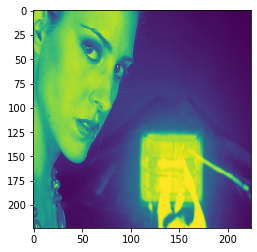

In [57]:
plt.imshow(grey_test[25])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


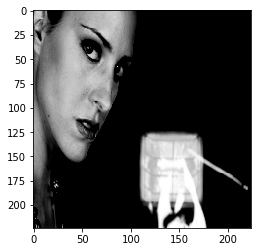

In [37]:
plt.imshow(auto_X_grey[25])

In [38]:
auto_split = int(0.95*len(auto_X_grey))

In [40]:
# Train grey images
X_train_grey = auto_X_grey[:auto_split]

In [41]:
len(X_train_grey)

4750

In [42]:
X_train_grey.dtype

dtype('float64')

In [43]:
print(X_train_grey.max(), X_train_grey.min())

1.0 -1.0


In [44]:
# Test grey images
X_test_grey = auto_X_grey[auto_split:]

In [45]:
len(X_test_grey)

250

In [46]:
# Train color images
X_train_color = imgs_output[:auto_split]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


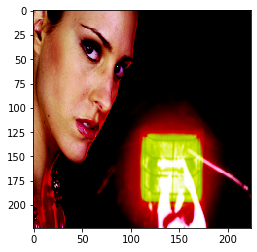

In [47]:
plt.imshow(X_train_color[25]);

In [48]:
# Test color images
X_test_color = imgs_output[auto_split:]

In [49]:
print(X_train_color.max(), X_train_color.min())

1.0 -1.0


In [50]:
X_train_grey.shape

(4750, 224, 224, 3)

In [51]:
X_test_grey.shape

(250, 224, 224, 3)

In [52]:
X_train_color.shape

(4750, 224, 224, 3)

In [53]:
X_test_color.shape

(250, 224, 224, 3)

In [54]:
X_train_grey = X_train_grey.reshape(X_train_grey.shape[0], 224, 224, 1)

ValueError: cannot reshape array of size 715008000 into shape (4750,224,224,1)

In [55]:
X_test_grey = X_test_grey.reshape(X_test_grey.shape[0], 224, 224, 1)

ValueError: cannot reshape array of size 37632000 into shape (250,224,224,1)

In [59]:
X_train_grey.shape

(4750, 224, 224, 3)

In [60]:
X_test_grey.shape

(250, 224, 224, 3)

# Baseline Encoder

In [95]:
# Baseline variables
batch_size=32
kernel_size=3
input_shape=(224,224,1)
filters_per_layer = [64,128,256]
strides = 2
activation = 'relu'
padding='same'

In [96]:
# Build the Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in filters_per_layer:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               activation=activation,
               padding=padding)(x)

In [97]:
# def autoencoder():
    
#     # Build the Encoder
#     encoder_input = Input(shape=(224,224,1))
#     encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
#     encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
#     encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
    
#     # Fusion
#     fusion_output = concatenate([encoder_output, fusion_output], axis=3)
    
#     # Decoder
#     decoder_output = 

In [98]:
# Latent Vector

latent_dim=256

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [99]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 256)       295168    
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               51380480  
Total params: 51,750,144
Trainable params: 51,750,144
Non-trainable params: 0
_______________________________________________

In [136]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(28*28*448)(latent_inputs)
x = Reshape((28,28,448))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in filters_per_layer[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        activation=activation,
                        padding=padding)(x)
#     x = UpSampling2D((2,2))(x)

outputs = Conv2DTranspose(filters=1, #channels
                          kernel_size=kernel_size,
                          activation='tanh',
                          padding=padding,
                          name='decoder_output')(x)

In [137]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 351232)            90266624  
_________________________________________________________________
reshape_6 (Reshape)          (None, 28, 28, 448)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 56, 56, 256)       1032448   
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 112, 112, 128)     295040    
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 224, 224, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 224, 224, 1)       577 

In [138]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 224, 224, 1)       0         
_________________________________________________________________
encoder (Model)              (None, 256)               51750144  
_________________________________________________________________
decoder (Model)              (None, 224, 224, 1)       91668481  
Total params: 143,418,625
Trainable params: 143,418,625
Non-trainable params: 0
_________________________________________________________________


In [139]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [140]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [141]:
callbacks=[lr_reducer]

In [73]:
# train the autoencoder
autoencoder.fit(X_train_grey,
                X_train_color,
                validation_data=(X_test_grey, X_test_color),
                epochs=5,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 4750 samples, validate on 250 samples
Epoch 1/5
4750/4750 [==============================] - 476s 100ms/step - loss: 0.0894 - val_loss: 0.1041
Epoch 2/5
4750/4750 [==============================] - 478s 101ms/step - loss: 0.0822 - val_loss: 0.1079
Epoch 3/5
4750/4750 [==============================] - 478s 101ms/step - loss: 0.0761 - val_loss: 0.1043
Epoch 4/5
4750/4750 [==============================] - 479s 101ms/step - loss: 0.0702 - val_loss: 0.1020
Epoch 5/5
4750/4750 [==============================] - 478s 101ms/step - loss: 0.0647 - val_loss: 0.1059


In [74]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(X_test_grey)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


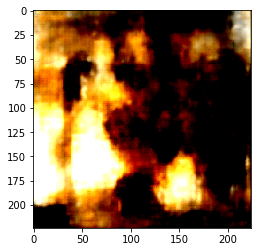

In [86]:
plt.imshow(x_decoded[10]*3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


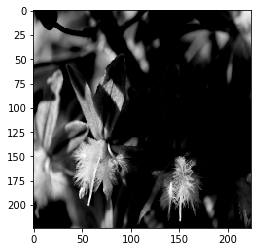

In [79]:
plt.imshow(X_test_grey[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


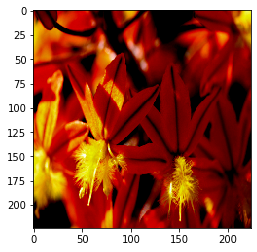

In [80]:
plt.imshow(X_test_color[10])

### Reconstructions may be lossy. We may need to train the model for longer, or make the encoder and decoder deeper, or make the codings larger. But if we make the network too powerful, it will manage to make perfect reconstructions without having learned any useful patterns in the data.

## "For example you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic."

# A second attempt

In [113]:
grey_test = rgb2gray(imgs_input)

In [114]:
grey_test.shape

(5000, 224, 224)

In [115]:
grey_train = grey_test[:auto_split]

In [116]:
grey_train.shape

(4750, 224, 224)

In [117]:
grey_test = grey_test[auto_split:]

In [118]:
grey_test.shape

(250, 224, 224)

In [119]:
grey_train = grey_train.reshape(grey_train.shape[0], 224, 224, 1)

In [120]:
grey_test = grey_test.reshape(grey_test.shape[0], 224, 224, 1)

In [122]:
# train the autoencoder
autoencoder.fit(grey_train,
                X_train_color,
                validation_data=(grey_test, X_test_color),
                epochs=10,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 4750 samples, validate on 250 samples
Epoch 1/10
4750/4750 [==============================] - 476s 100ms/step - loss: 0.1400 - val_loss: 0.1345
Epoch 2/10
4750/4750 [==============================] - 485s 102ms/step - loss: 0.1240 - val_loss: 0.1239
Epoch 3/10
4750/4750 [==============================] - 480s 101ms/step - loss: 0.1137 - val_loss: 0.1144
Epoch 4/10
4750/4750 [==============================] - 486s 102ms/step - loss: 0.1055 - val_loss: 0.1084
Epoch 5/10
4750/4750 [==============================] - 503s 106ms/step - loss: 0.0979 - val_loss: 0.1056
Epoch 6/10
4750/4750 [==============================] - 513s 108ms/step - loss: 0.0917 - val_loss: 0.1047
Epoch 7/10
4750/4750 [==============================] - 511s 108ms/step - loss: 0.0838 - val_loss: 0.1051
Epoch 8/10
4750/4750 [==============================] - 513s 108ms/step - loss: 0.0766 - val_loss: 0.1009
Epoch 9/10
4750/4750 [==============================] - 527s 111ms/step - loss: 0.0706 - val_loss: 0.1004

In [123]:
# predict the autoencoder output from test data
grey_decoded = autoencoder.predict(grey_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


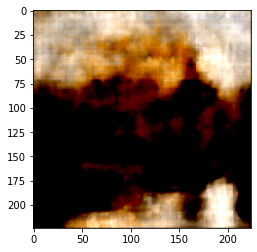

In [134]:
plt.imshow(grey_decoded[25]*2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


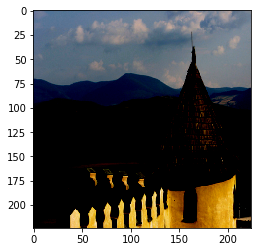

In [127]:
plt.imshow(X_test_color[25])

In [125]:
# Visualizing the Reconstructions

# def plot_image(image):
#     plt.imshow(image, cmap='binary')
#     plt.axis('off')

# def show_reconstruction(model, n_images=5):
#     reconstruction = model.predict(x_valid[:n_images])
#     fig = plt.figure(figsize=(n_images * 1.5, 3))
#     for image_index in range(n_images):
#         plt.subplot(2, n_images, 1 + image_index)
#         plot_image(X_valid[image_index])
#         plt.subplot(2, n_images, 1 + n_images + image_index)
#         plot_image(reconstruction[image_index])

# show_reconstructons(stacked_ae)

## Purely for science

In [142]:
# train the autoencoder
autoencoder.fit(grey_train,
                grey_train,
                validation_data=(grey_test, grey_test),
                epochs=10,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 4750 samples, validate on 250 samples
Epoch 1/10
4750/4750 [==============================] - 475s 100ms/step - loss: 0.1415 - val_loss: 0.0722
Epoch 2/10
4750/4750 [==============================] - 483s 102ms/step - loss: 0.0571 - val_loss: 0.0573
Epoch 3/10
4750/4750 [==============================] - 482s 101ms/step - loss: 0.0512 - val_loss: 0.0549
Epoch 4/10
4750/4750 [==============================] - 482s 102ms/step - loss: 0.0475 - val_loss: 0.0540
Epoch 5/10
4750/4750 [==============================] - 485s 102ms/step - loss: 0.0442 - val_loss: 0.0531
Epoch 6/10
4750/4750 [==============================] - 485s 102ms/step - loss: 0.0404 - val_loss: 0.0535
Epoch 7/10
4750/4750 [==============================] - 484s 102ms/step - loss: 0.0369 - val_loss: 0.0539
Epoch 8/10
4750/4750 [==============================] - 486s 102ms/step - loss: 0.0335 - val_loss: 0.0555
Epoch 9/10
4750/4750 [==============================] - 485s 102ms/step - loss: 0.0302 - val_loss: 0.0558

In [143]:
# predict the autoencoder output from test data
test_decoded = autoencoder.predict(grey_test)

In [149]:
# test_grey = prep_L(test_decoded, batch_size=250)

# Further Autoencoder Notes

In [150]:
# If you are working with images, these autoencoders will not work well, unless
# the images are very small. CNNs are far better suited than dense networks to work
# with images. So if you want to build an autoencoder for images you will need to
# build a convolutional autoencoder.

# The encoder is a regular CNN composed of conv layers and pooling layers. It
# typically reduces the spatial dimensionality of the inputs (heights and widths)
# while increasing the depth (i.e. the number of feature maps. The decoder must
# do the reverse (upscale the image and reduce its depth back tot he original
# dimensions), and for this you can transpose conv layers (alternatively, you could
# combine upsampling layers with conv layers). 

# conv_encoder = keras.models.Sequential([
#                keras.layers.Reshape([28, 28, 1], input_shape=[224,224,1]),
#                keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
#                keras.layers.MaxPool2D(pool_size=2),
#                keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
#                keras.layers.MaxPool2D(pool_size=2),
#                keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
#                keras.layers.MaxPool2D(pool_size=2)
# ])

# conv_decoder = keras.models.Sequential([
#                keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, 
#                                             padding='valid', activation='selu',
#                                             input_shape=[3,3,64]),
#                keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
#                                             activation='selu'),
#                keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
#                                             activation='sigmoid'),
#                keras.layers.Reshape([28,28])
# ])

# conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [ ]:
# The following code builds up a simple linear autoencoder to perform PCA on a
# 3D dataset, projecting it to 2D.

# from tensorflow import keras

# encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
# decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
# autoencoder = keras.models.Sequential([encoder, decoder])

# autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))

# We organized the autoencoder into two subcomponents: the encoder and the decoder.
# Both are regular Sequential models with a single Dense layer each, and the
# autoencoder is a Sequential model containing the encoder followed by the decoder.
# Remember, a model can be used as a layer in another model.
# The autoencoder's number of outputs is equal to thenumber of inputs (3).
# To perform simple PCA, we do not use any activation function (all neurons are
# linear), and the cost function is the MSE.
# Now let's train the model on a simple generated 3D dataset and use it to encode
# that same dataset.

# history = autoencoder.fit(X_train, X_train, epochs=20)
# codings = encoder.predict(X_train)

# Note that the same dataset, X_train, is used as both the inputs and the targets.

In [ ]:
# Stacked Autoencoders
# Just like other NN's, autoencoders can have multiple hidden layers. In this case
# they are called stacked autoencoders, or deep autoencoders. Adding more layers
# helps the autoencoder learn more complex codings. That said, one must be careful
# not to make the autoencoder too powerful. Such an encoder may learn the training
# data perfectly, but it will not have learned any useful data representations
# in the process, and is unlikely to generalize to new instances. Stacked auto
# encoders look like a sandwhich-- mirror down and up.

# stacked_encoder = keras.models.Sequential([
#                   keras.layers.Flatten(input_shape=[28,28]), # now a vector of 784
#                   keras.layers.Dense(100, activation='selu'),
#                   keras.layers.Dense(30, activation='selu')])

# stacked_decoder = keras.models.Sequential([
#                   keras.layers.Dense(100, activation='selu', input_shape=[30]),
#                   keras.layers.Dense(28*28, activation='sigmoid'),
#                   keras.layers.Reshape([28,28])
# ])

# stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder]),
# stacked_ae.compile(loss='binary_crossentropy', optimizer = keras.optimizers.SGD(lr=0.5))

# history = stacked_ae.fit(X_train, X_train, epochs = 10, validation_data = [X_valid, X_valid])

# Just like earlier, we split the autoencoder into two submodels, the encoder and 
# the decoder. The encoder takes 28x28 greyscale images, flattens them so that each
# image is represented as a vector fo size 784, then processes these vectors through
# two Dense layers of diminishing sizes (100 units the 30 units), both using the 
# SELU activation function (you may want LeCun Normalization as well). For each
# input image, the encoder outputs a vector of size 30.
# The decoder takes codings of size 30 (output by the encoder) and processes them
# through two Dense layers of increasing sizes (100 units, then 784 units), and it 
# reshapes the final vectors into 28x28 arrays s the decoder's outputs have the same shape as the
# encoder's inputs. When compiling the stacked autoencoder, we use the binary cross entropy
# loss instead of mean squared error. We are treating the reconstruction task as a
# multilabel binary classification problem: each pixel intensity represents the prob
# that the pixel should be black. Framing it this way (rather than as regression) tends
# to make the model converge faster. You might be tempted to use the accuracy metric, but
# it would not work properly, since this metric expects the labels to be either 0 or 1
# for each pixel. You can easily work around this problem by creating a custom metric
# that computes the accuracy after rounding the targets and predictions to 0 and 1.

# Visualizing the Reconstructions

# def plot_image(image):
#     plt.imshow(image, cmap='binary')
#     plt.axis('off')

# def show_reconstruction(model, n_images=5):
#     reconstruction = model.predict(x_valid[:n_images])
#     fig = plt.figure(figszie=(n_images * 1.5, 3))
#     for image_index in range(n_images):
#         plt.subplot(2, n_images, 1 + image_index)
#         plot_image(X_valid[image_index])
#         plt.subplot(2, n_images, 1 + n_images + image_index)
#         plot_image(reconstruction[image_index])

# show_reconstructons(stacked_ae)

# Reconstructions may be lossy. We may need to train the model for longer, or make
# the encoder and decoder deeper, or make the codings larger. But if we make the
# network too powerful, it will manage to make perfect reconstructions without
# having learned any useful patterns in the data.

In [ ]:
# When an autoencoder is neatly symmetrical, like the one we just built, a common
# technique is to tie the weights of the decoder layers to the weights of the 
# encoder layers. This halves the number of weights in the model, speeding up
# training and limiting the risk of overfitting. To tie weights in Keras:

# class DenseTranspose(keras.layers.Layer):
#     def __init__(self, dense, activation=none, **kwargs):
#       self.dense = dense
#       self.activation = keras.activations.get(activation)
#       super().__init__(**kwargs)
#     def build(self, batch_input_shape)
#       self.biases = self.add_weight(name='bias', initializer='zeros',
#                                     shape=[self.dense.input_shape[-1]])
#       super().build(batch_input_shape)
#     def call(self, inputs):
#       z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
#       return self.activation(z+self.biases)

# This custom layer acts like a regular Dense layer, but it uses another Dense layer's
# weights, tranposed (transpose_b=True) is equivalent to tranposing the second
# argument, but it's more efficient as it performs the transposition on the fly
# with the matmul() operation. However, it uses its own bias vector. Next, we can
# build a new stacked autoencoder, much like the previous one, but with the decoder's
# Dense layers tied to the encoder's Dense layers.

# dense_1 = keras.layers.Dense(100, activation='selu')
# dense_2 = keras.layers.Dense(30, activation='selu')

# tied_encoder = keras.models.Sequential([
#                                         keras.layers.Flatten(input_shape=[28, 28]),
#                                         dense_1,
#                                         dense_2
# ])

# tied_decoder = keras.models.Sequential([
#                                         DenseTranspose(dense_2, activation='selu'),
#                                         DenseTranspose(dense_1, activation='sigmoid'),
#                                         keras.layers.Reshape([28,28])
# ])

# tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

# Can achieve a lower reconstruction error than the previous, with almost half the parameters